## Notes

- Position of the cut-out: For AX Cir and possibly also V659 Cen the position of the Cepheid is off. THe companion is so bright that is has diffraction spikes, too, and thus the fit of the diffraction spikes for the position is not good enough. -> Probably need to correct by hand.

- Positions from diffraction spikes. Looking at the images devided by the median images, the diffraction spikes are clearly sometimes too high and sometimes too low. -> Investigate! Is that just the +/- 0.5 pixels because I extract at complete pixels? Or is the centering not as good as it could be?
 
- LOCI: LOCI fits generally look better, but they need **source free templates**. In some cases, companions from other images are mirrored positive or negative through the PSF fit. In global fits the images with companions will just receive a very low weight (because the companions do not fit, so effetively all base iamges with companions do not contribute and thus I'm effectively fitting far fewer bases than I thought - presumably that's why my LOCI fits look so much better), but in LOCI the optimization region != fit region. If a base that has a bright companion in the region get just a little weight, the companion will show up in the final image (because it's much brighter than the average sky, even a small coefficient will be enough to make that important). -> need to mask companions *before* first LOCI round. **Iterative approach**. (Later when I run simulations, I can just use the clenad bases set, so it's OK if there is some manual interaction.

- LOCI: There are still some sectors for some images that are not fit well.

In [121]:
import os
from glob import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, vstack
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.stats import median_absolute_deviation
from astropy.coordinates import SkyCoord
from astropy import units as u
from wcsaxes import WCSAxes
import photutils
from ccdproc import ImageFileCollection

# This can be cleaned up once psfsubtraction set a few __all__ or has import in the __init__.py files
import psfsubtraction
#import psfsubtraction.fitpsf
#import psfsubtraction.fitpsf.fitters
#import psfsubtraction.fitpsf.fitregion
#import psfsubtraction.prepare.center

%matplotlib inline

In [33]:
import ipyparallel

rc = ipyparallel.Client()
dview = rc[:]
lview = rc.load_balanced_view()
print len(dview)

10


In [34]:
# Just checking where the engines are running

@dview.remote(block=True)
def getpid():
    import os
    return os.environ['HOST']

getpid()

['melkor.mit.edu',
 'melkor.mit.edu',
 'melkor.mit.edu',
 'melkor.mit.edu',
 'vex.mit.edu',
 'MKX.MIT.EDU',
 'MKX.MIT.EDU',
 'MKX.MIT.EDU',
 'MKX.MIT.EDU',
 'inconceivable']

In [4]:
datadir = '/melkor/d1/guenther/processing/Cepheids/PSFsubtr/'
outdir = '/melkor/d1/guenther/projects/Cepheids/HSTsnapshot/'

In [5]:
keys = ['TARGNAME', 'FILTER', 'ASN_ID', 'RA_TARG', 'DEC_TARG', 'DATE-OBS', 'TIME-OBS', 'EXPTIME']
fitslist = ImageFileCollection(datadir, keywords=keys)

In [6]:
fitslist.sort(['FILTER', 'TARGNAME'])

Our goal is to select sub-images that are all centered on the bright Cepheid. Since the Cepheids are all significantly over-exposed and saturated, we cannot just look for the brihgtest pixel. Instead, we make an inital guess based on the center of mass of the image and then fit lines to the diffraction spikes and use the intersection point as the source position. To make sure that the fit of the diffraction spike is not skewed by the presence of a source close to it, we select a region that is only a few pixels wide for the fit.

In [7]:
initial_guess = functools.partial(psfsubtraction.prepare.center.guess_center_nested, halfwidth=150)

def read_images(filelist, halfwidth, width=5):
    '''Read files, make header wrappers for WCS'''
    images = np.ma.zeros((2 * halfwidth + 1, 2 * halfwidth + 1, len(filelist)))
    targets = []

    for i, f in enumerate(filelist):
        if np.mod(i, 20) == 0:
            print 'working on file {0}'.format(i)
        hdus = fits.open(f)
        xm, ym = psfsubtraction.prepare.center.center_from_spikes(hdus[0].data, width=width,
                                    initial_guess=initial_guess)
        # Note (ym, xm), because ordering of axis differs!
        cutout = Cutout2D(hdus[0].data, (ym, xm), 2 * halfwidth + 1, wcs=WCS(hdus[0].header))
        hdus.close()
        targets.append(cutout)
        images[:, :, i] = cutout.data
    return images, targets


\section{Observations and data reduction}
\label{sect:obs}

We observed a sample of 70 Cepheides with the \emph{Hubble Space Telescope} using the WFC3 camera to search for binary companions. The data are described in detail in \textbf{insert reference here}. Briefly, each object was observed using two filters (\texttt{F621M} and \texttt{F845M}) which are medium bandpass filteres centered on 621~nm and 845~nm. In each filter, three dither positions were observed with exposure times of a few seconds. The exposure times are set such that the central Cepheid is overexposed by about a factor of a hundred, totally saturating the central part of its point-spread function (PSF). This is necessary to collect sufficient signal for any late-type main sequence companion. In the first paper we dealt with companions located more than 5\arcsec{} from the central source. Here, we concentrate on close companions which can be found aft5er a detailed PSF subtraction.
As described in \textbf{insert reference here}, the data are \textbf{insert what Evan did here if he did more than I say}
reduced using the standard HST/WFC3 pipeline and combined into drizzeled images. 


In [8]:
halfwidth = 80
cutsize = 2 * halfwidth + 1
cutshape = (cutsize, cutsize)
F621Marr, F621M = read_images(fitslist.files_filtered(FILTER='F621M', include_path=True), halfwidth=halfwidth, width=25)
F845Marr, F845M = read_images(fitslist.files_filtered(FILTER='F845M', include_path=True), halfwidth=halfwidth)

working on file 0
working on file 20
working on file 40
working on file 60
working on file 0
working on file 20
working on file 40
working on file 60


In [9]:
F621names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F621M']
F845names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F845M']
assert np.all(F621names == F845names)

In [10]:
def plot_gallery(images, names, nrows=5, ncols=4):
    '''
    Parameters
    ----------
    images : 3d np.array 
        3d array with images stacked along the last dimension
    '''
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))
    plt.setp(axes.flat, xticks=[], yticks=[])
    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            axes[i, j].imshow(images[:,:,index])
            axes[i, j].set_title(names[index])
            ax = fig.add_subplot()
    fig.subplots_adjust(hspace=0.002, wspace=0.04)
    return fig

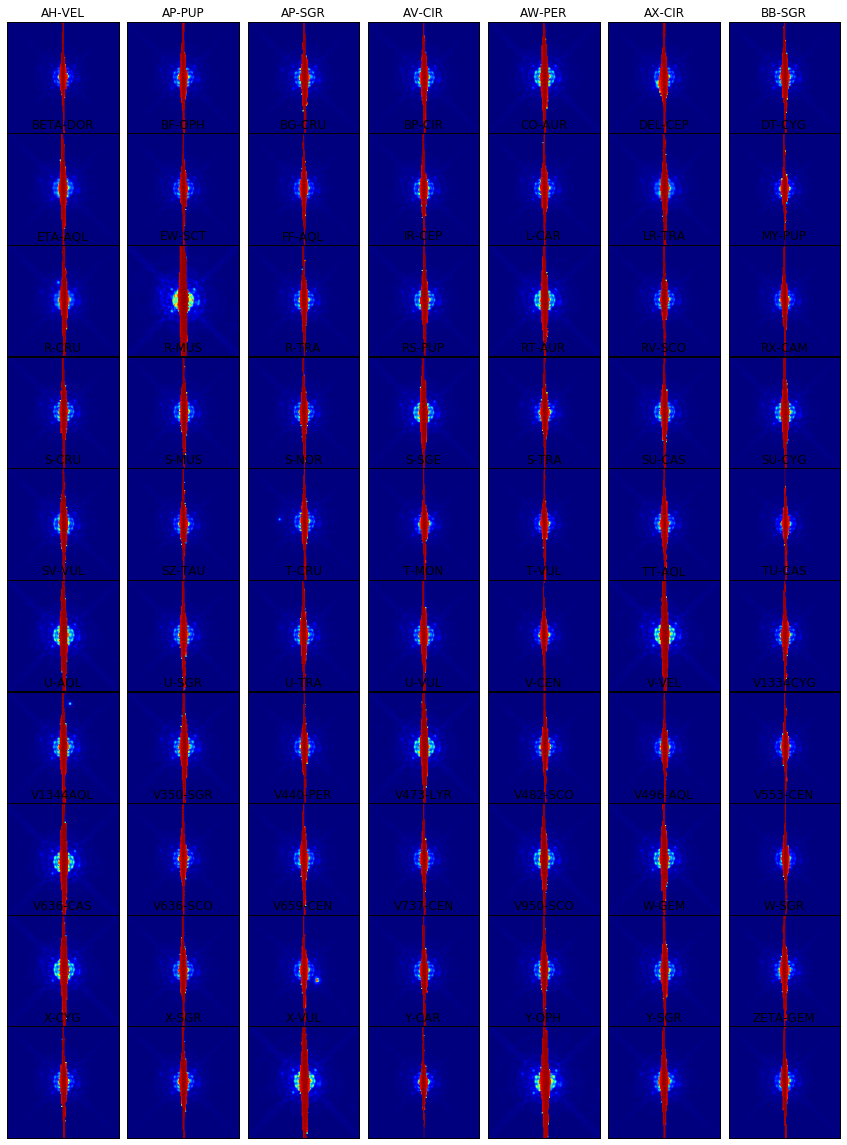

In [11]:
fig = plot_gallery(F845Marr, F621names, 10, 7)

(0, 1)

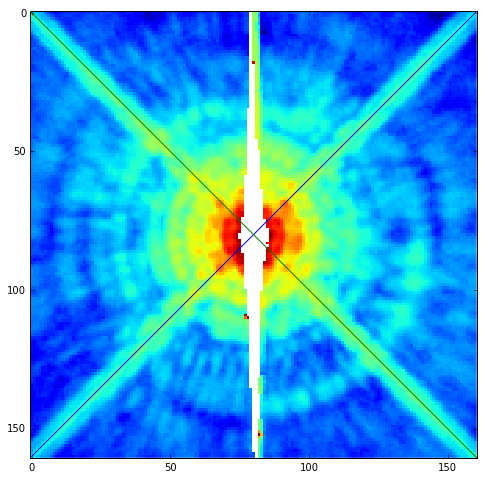

In [21]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
axs.imshow(np.log(F621Marr[:,:,3]), interpolation="none")
fig.canvas.draw()
box = axs._position.extents
tmpax = fig.add_axes([box[0], box[1], box[2]-box[0], box[3]-box[1]])
tmpax.set_axis_off()
tmpax.plot([0,1], [0,1])
tmpax.plot([0,1], [1, 0])
tmpax.set_ylim(0,1)
tmpax.set_xlim(0, 1)

(0, 1)

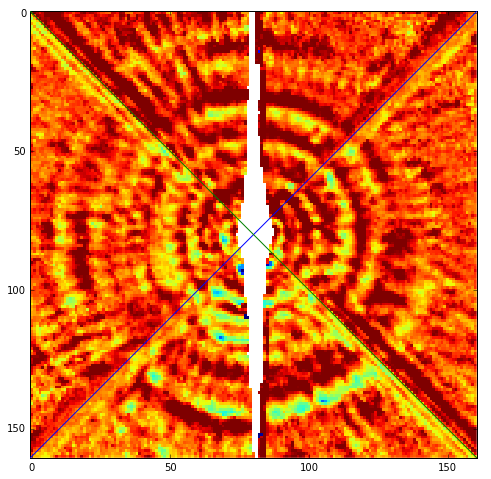

In [27]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
axs.imshow(np.log(F621Marr[:,:,2]/F621Marr[:,:,3]), interpolation="none", vmin=-1, vmax=1)
fig.canvas.draw()
box = axs._position.extents
tmpax = fig.add_axes([box[0], box[1], box[2]-box[0], box[3]-box[1]])
tmpax.set_axis_off()
tmpax.plot([0,1], [0,1])
tmpax.plot([0,1], [1,0])
tmpax.set_ylim(0,1)
tmpax.set_xlim(0, 1)

In [14]:
def mask_saturated(images, maskingfunc):
    '''Mask pixels above a certain value
   
    Parameters
    ----------
    image : np.array
        2d or 3d array of images (if 2d, then array of flattend images)
    maskingfunc : callable
        This function is called for every image. It returns as boolean mask
        that is ``True`` for all values that should be masked.
    '''
    for i in range(images.shape[-1]):
        images[maskingfunc(images[..., i]), i] = np.ma.masked
    return images

In [15]:
F621Marr = mask_saturated(F621Marr, lambda x: x > 0.6 * x.max())
F845Marr = mask_saturated(F845Marr, lambda x: x > 0.6 * x.max())

In [16]:
normperimF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=0)
normperimF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=0)

medianimF621 = np.ma.median(F621Marr.reshape((-1, F621Marr.shape[-1])), axis=1)
medianimF621 /= np.ma.median(medianimF621)
medianimF845 = np.ma.median(F845Marr.reshape((-1, F845Marr.shape[-1])), axis=1)
medianimF845 /= np.ma.median(medianimF845)

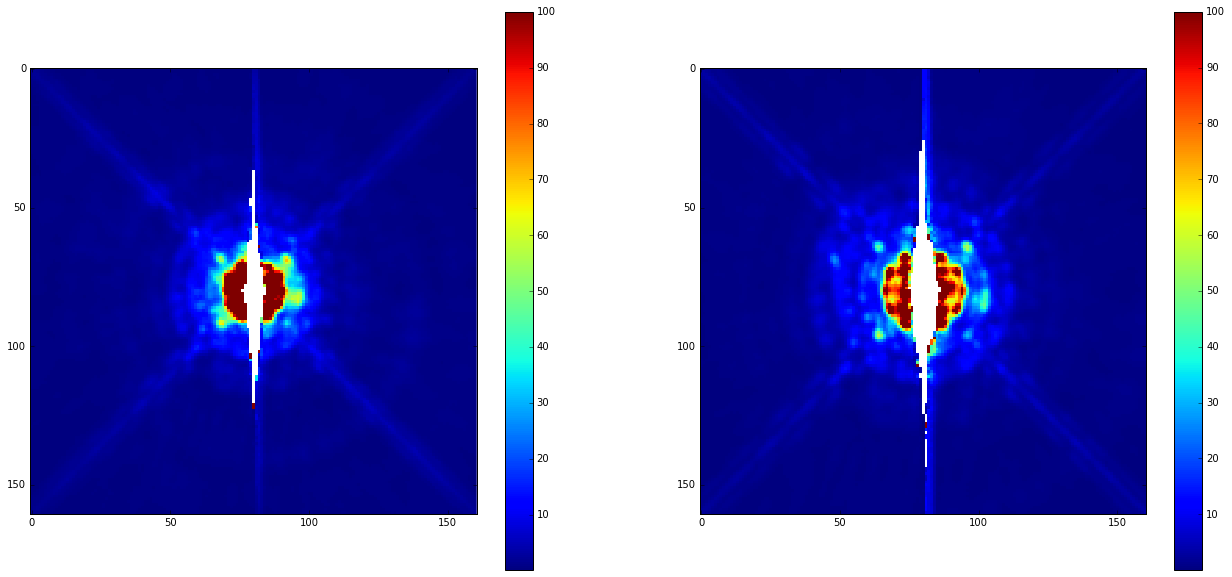

In [17]:
%matplotlib inline

fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(medianimF621.reshape(cutshape), interpolation='none', vmax=100)
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(medianimF845.reshape(cutshape), interpolation='none', vmax=100)
plt.colorbar(im2, ax=ax2)
             

In [18]:
def apply_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr /= normperim[None, :]
    arr /= normim[:, None]
    return arr.reshape(shape)

def remove_mediannorm(arr, normperim, normim):
    shape = arr.shape
    arr = arr.reshape((-1, shape[-1]))
    arr *= normperim[None, :]
    arr *= normim[:, None]
    return arr.reshape(shape)

\section{PSF subtraction}

\subsection{Introduction}
referneces here

\subsection{mmm}
 - cutout based on centering based on spikes
-masking saturated pixels
- cannot transfomr bases like KLIP because of masked pixels
- fit different regions / bases


We apply two transformations to the drizzeled images in order to normalize them in a way that increases the numerical stability of the PSF fitting. After masking pixels that are saturated, we divide each image by its median value. Given the size of the images, the median value represents the power in the wings of the Cephedid PSF, so this transformation brings all iamges on a similar scale despite the different exposure times and magnituudes of the Cepheids. Second, we devide each image by the median image. Our fitting procedure is essentially a $\chi^2$ optimization with equal weights for each pixel (see below). The error term that is minimized in such a procedure it dominated the by pixels with the largest \emph{absolute} deviation. These are found in the inner part of the PSF, usually just next to the saturated pixels. However, these pixels are very uncertain for fitting the PSF, because we cannot exclude that some of them have received extra charge through bleeding. Also, our masking procedure means that those pixels are often covered by few bases only in the fit, again making the fit less reliable. By dividing each image by the median image, we ensure that the absolute numerical value in each pixel is similar, putting more weight on the other parts of the PSF.

In [19]:
normF621 = apply_mediannorm(F621Marr.copy(), normperimF621, medianimF621)
normF845 = apply_mediannorm(F845Marr.copy(), normperimF845, medianimF845)

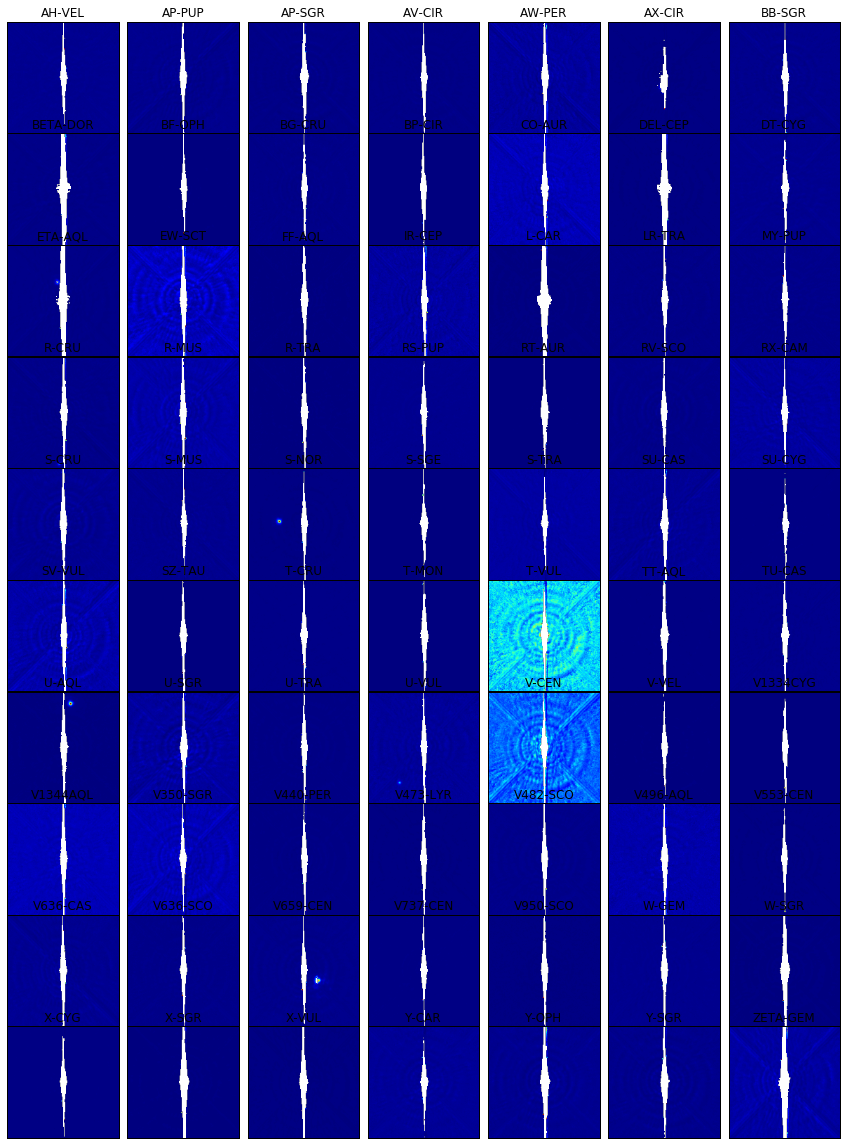

In [39]:
fig = plot_gallery(normF621, F621names, 10, 7)

In [40]:
def detect_sources(image, threshold=7, **kwargs):
    bkg_sigma = 1.48 * median_absolute_deviation(image)
    return photutils.daofind(image, threshold=7 * bkg_sigma, **kwargs)

In [61]:
daofindkwargs = {'fwhm': 1.5, 'roundlo': -0.8, 'roundhi': 0.8}
#initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_621]
#initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_845]

initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(normF621, 2)]
initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(normF845, 2)]

In [65]:
initial_sources = combine_source_tables(initial_sources_621, initial_sources_845, F621names)

In [81]:
indnames = np.zeros(70, dtype=bool)
for i in range(70):
    if F621names[i] in ['ETA-AQL', 'AX-CIR', 'S-NOR', 'U-AQL', 'U-VUL',
                        'V659-CEN', 'R-CRU', 'SV-VUL', 'V-CEN']:
        indnames[i] = True

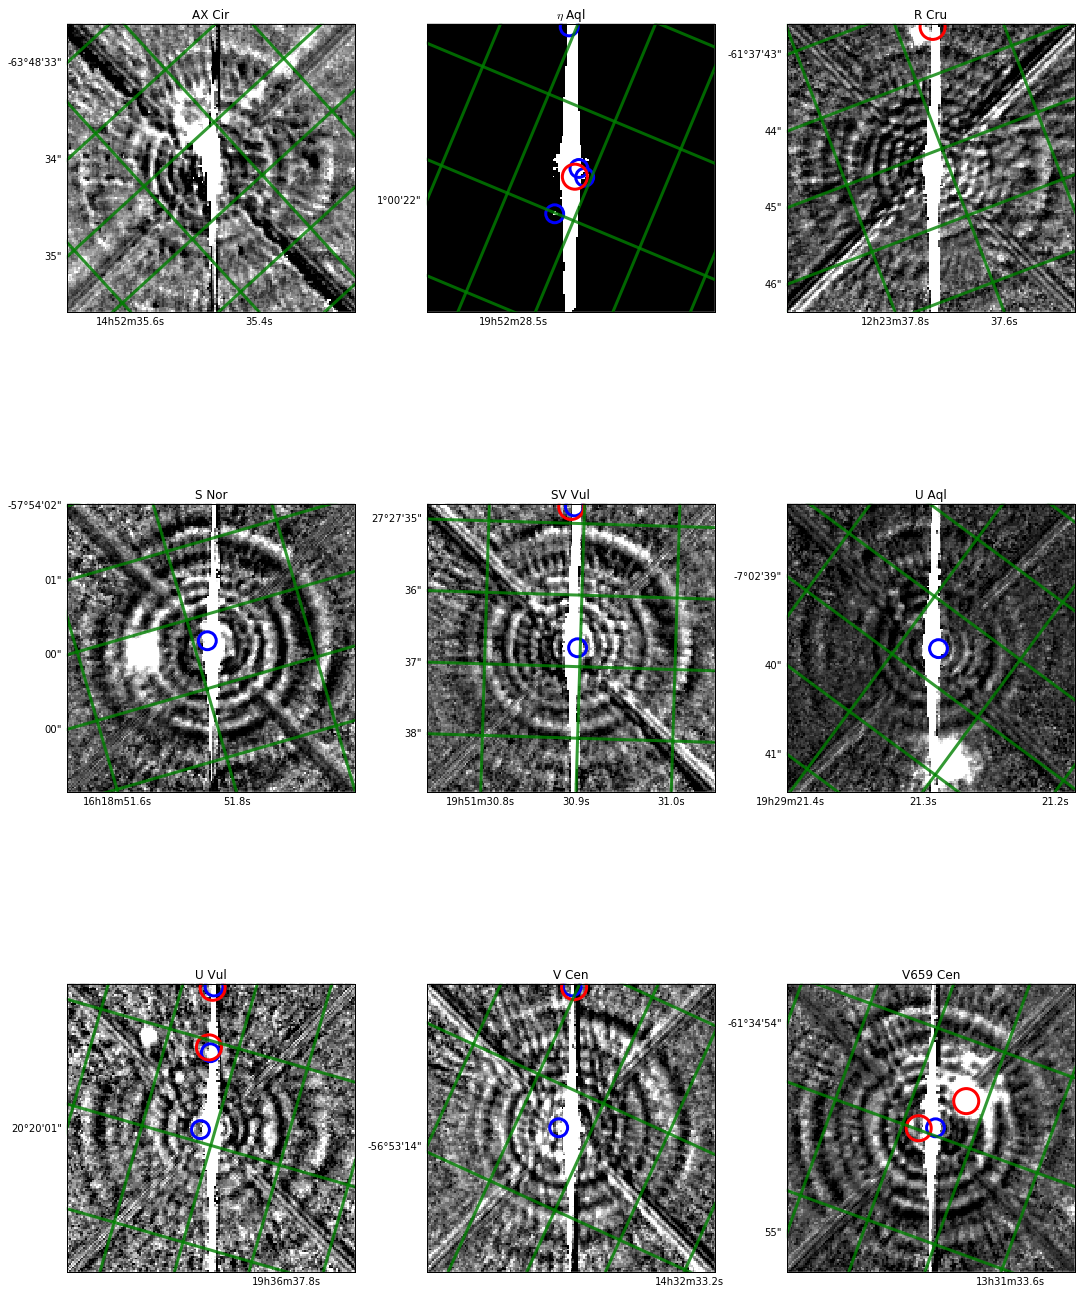

In [195]:
#indnames= np.ones(70, dtype=bool)
fig = plot_gallery_source(normF621[:,:,indnames], np.array(F621names)[indnames], 
                          np.array(F621M)[indnames],
                          initial_sources[initial_sources['flux'] > 1e3], 
                          3, 3)

Based on the above, I'm now going to hand-select regions that shall be masked in the psfbase, because we don't want any region in there that has a companion, otherwise the LOCI algorithm will give us evil subtractions.
This list is iterative and will be extended further down.

In [369]:
for i in range(70):
    if F621names[i] == 'U-VUL':
        print i
        break

initial_sources_621[i]

45


<Table length=4>
  id    xcentroid     ycentroid   ...      peak          flux          mag      
int64    float64       float64    ...    float64       float64       float64    
----- ------------- ------------- ... ------------- ------------- --------------
    1 74.2118416463 78.9829731588 ... 8834.18457031 8038.98719369 -9.76300334205
    2 79.7376024998 121.971050073 ... 10089.1171875 9640.09298988 -9.96020305799
    3 45.0042691777 131.313599727 ... 8.28374675817 5.88755879089 -1.92483814214
    4 81.7705930278  158.73196869 ... 9712.34960938 9492.83120433 -9.94348939646

In [370]:
t = F621M[i]
posindeg = t.wcs.all_pix2world(40, 130, 0)
print posindeg

[array(294.1567393415313), array(20.33343735578631)]


In [275]:
SkyCoord('16h18m51.7s-57d54m00s')

<SkyCoord (ICRS): (ra, dec) in deg
    (244.71541667, -57.9)>

In [271]:
def name2index(name):
    for i in range(70):
        if F621names[i] == name:
            break
    return i

def plot_name(name, circlestab):
    i = name2index(name)
    print i
    t = F621M[i]

    fig = plt.figure()
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=t.wcs)
    fig.add_axes(ax) 
    im = ax.imshow(F621Marr[..., i]/medianimF621.reshape((161,161)), cmap=plt.cm.gist_heat,
                   origin='lower', interpolation='nearest')

    ra = ax.coords['ra']
    dec = ax.coords['dec']
    ra.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
    dec.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
    ra.set_major_formatter('hh:mm:ss.s')
    for line in circlestab[circlestab['TARGNAME'] == name]:
        print line
        x,y = t.wcs.all_world2pix(line['RA']*u.deg, line['DEC']*u.deg, 0)
        print x,y
        circr = mpl.patches.Circle((x, y), 
                                   radius=line['radius_in_pix'], 
                                   edgecolor='green', facecolor='none')

        ax.add_patch(circr)

In [393]:
# This table holds PRILIMINARY detection (as seen by hand).
# Those regions need to be masked in
# - the PSF base (because they are not part of the PSF)
# - in the manual_fitmask of the data of the fitters (because they should not be part of the
#   optimization regions, since this is not a PSF feature).

# First iteration of this table (as seen in this cell) is by hand from the image above.

excludetab = Table(rows = [('AX-CIR', 223.14685, -63.80977, 10),
                           ('V659-CEN', 202.8888, -61.58242, 6),
                           ('ETA-AQL', 298.11834, 1.00564, 6),
                           ('R-CRU', 185.906499, -61.62872, 6),
                           ('S-NOR', 244.71548, -57.89993, 6),
                           ('U-AQL', 292.33874,  -7.04437, 6),
                           ('U-VUL', 294.156715,  20.33341, 6)],
                    names = ['TARGNAME', 'RA', 'DEC', 'radius_in_pix'])

# In case I ever use a different pixel scale.
excludetab['rad_in_arcsec'] = 0.25 * excludetab['radius_in_pixels']

45
TARGNAME     RA       DEC    radius_in_pix
-------- ---------- -------- -------------
   U-VUL 294.156715 20.33341             6
44.6946808538 132.068893853


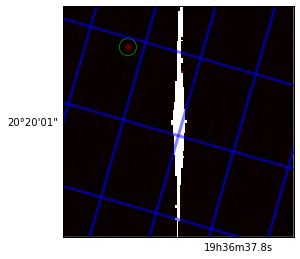

In [394]:
plot_name('U-VUL', excludetab)

In [29]:
daofindkwargs = {'fwhm': 1.5, 'roundlo': -0.8, 'roundhi': 0.8}
initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_621]
initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in initial_fits_845]

#initial_sources_621 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(reduced_images621, 2)]
#initial_sources_845 = [detect_sources(r, threshold=5, **daofindkwargs) for r in np.rollaxis(reduced_images845, 2)]

In [ ]:
# loop over names...
def mask_out_suspected_source(image, (x0, y0), r_in_pix):
    x, y = np.indices(image.shape)
    
    # for data, do this to manual_fitmask
    image.mask[(x-x0)**2+(y-y0)**2 < r_in_pix**2] = True

### The followign few cells are outdated. I use a real LOCI fitter now.

In [20]:
def remove_img_from_psfbase(base, i):
    '''
    Parameters
    ----------
    base : np.array
        This is an array of stacked 1 or 2 d images for the bases. 
        The last dimension is the number of bases. 
    i : int, list or array of bools
        which base should be removed?
    
    Returns
    -------
    smaller_base : np.array
        Copy of base with hte specified images removed.
    '''
    ind = np.ones(base.shape[-1], dtype=bool)
    ind[i] = False
    return base[..., ind]

In [28]:
'''
Now, I run some examples with different parameters. 
I will compare them below (interactively by hand, not all plots are available in this notebook)
to determine the best parameters.

(Most of these calls can run on an engine in parallel.)
'''
# mask the bases with a stricter limit than the image data
# My idea is the following:
#    If the image data is bad, then there is nothing we can do about itb
#    but if the data in any base is bad, I can just not use that base for the pixel in question.
#    If we do us a signel bad base, that pixel is probably screwed up for the analysis, so it might be 
#    beneficial to use fewer bases when in doubt than risking a single base that is saturated.

# run examples on AV Cir, which has a compagnion.
i = 3
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .4 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.UseAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])
async1 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.UseAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])
async2 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .8 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.UseAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])
async3 = lview.map_async(lambda x: x.remove_psf(), [f])

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > 1 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.UseAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])

async4 = lview.map_async(lambda x: x.remove_psf(), [f])

# Now, we repeat async2, but require a minimum number of bases. This is
# - faster (because fewer regions need to be evaluated)
# - fits that use just one or two bases are probably not very good anyway, so it might be better to have those
#   regions masked than to have bogus numbers in the result.
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.UseAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])
f.min_number_of_bases = 35
async5 = lview.map_async(lambda x: x.remove_psf(), [f])

In [29]:
# Repeat async2. Perform the subtraction on all pixels availble, but do *not* use the pixels
# very close to the center in the fitting.
# Because the class is defined interactively, I cannot easily ship it off to an engine.
# I can still wrap the result in a list, so that is looks the same as the async results.
#import psfsubtraction.fitpsf.optregion
class fitter_except_center(psfsubtraction.fitpsf.UseAllPixelsSubtraction):
    fitregion = psfsubtraction.fitpsf.wrapper_optmask(
                        psfsubtraction.fitpsf.optregion.all_unmasked)

F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = fitter_except_center(remove_img_from_psfbase(normF621.copy(), 0), normF621[..., i])
f.fitmask = np.max(F621_stricter_masking.mask.reshape((-1, 70)), axis=1)
async6 = [f.remove_psf()]

In [30]:
F621_stricter_masking = mask_saturated(F621Marr.copy(), lambda x: x > .6 * x.max())
F621_base = np.ma.array(normF621.copy(), mask=F621_stricter_masking.mask, copy=True)
f = psfsubtraction.fitpsf.fitters.LOCIAllPixelsSubtraction(remove_img_from_psfbase(F621_base, i), normF621[..., i])
f.min_number_of_bases = 35
async7 = lview.map_async(lambda x: x.remove_psf(), [f])

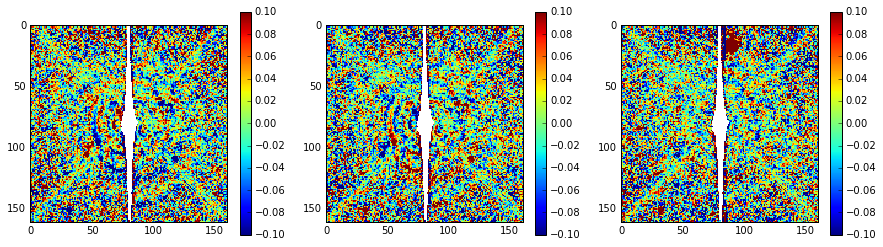

In [31]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(async6[0] - async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im1, ax=ax1)
ax2 = fig.add_subplot(132)
#im2 = ax2.imshow(async6[0], vmin=-.1, vmax=.1, interpolation="nearest")
#plt.colorbar(im2, ax=ax2)
ax2 = fig.add_subplot(132)
im2 = ax2.imshow(async5.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im2, ax=ax2)
ax3 = fig.add_subplot(133)
im3 = ax3.imshow(async7.get()[0], vmin=-.1, vmax=.1, interpolation="nearest")
plt.colorbar(im3, ax=ax3)
                                                                       

In [32]:
'''
Comparing the experiments above by eye, I see that there is not obvious *best* solution,
e.g. comparing results 2 and 6, I see that the one works better on the left of the Cepheid, the other one on the
right side. One is slightly better in the center, the other one on the edge of the diffraction spikes.

Obviously, the results will also be slightly different for different images, but for those examples that I looked
at by eye it holds that differenes are small and there is no best solution.
Thus, I now pick, somewhat arbitrarily the parameters that will be applied to the full dataset:

Given that we don't loose much useful data, I will set min_number_of_bases = 35 which reduces runtime by about 50%.
Also, for simplicity, we'll use the same masks for data and bases.
'''

"\nComparing the experiments above by eye, I see that there is not obvious *best* solution,\ne.g. comparing results 2 and 6, I see that the one works better on the left of the Cepheid, the other one on the\nright side. One is slightly better in the center, the other one on the edge of the diffraction spikes.\n\nObviously, the results will also be slightly different for different images, but for those examples that I looked\nat by eye it holds that differenes are small and there is no best solution.\nThus, I now pick, somewhat arbitrarily the parameters that will be applied to the full dataset:\n\nGiven that we don't loose much useful data, I will set min_number_of_bases = 35 which reduces runtime by about 50%.\nAlso, for simplicity, we'll use the same masks for data and bases.\n"

In [35]:
from psfsubtraction.fitpsf.fitters import CepheidSnapshotpaper as CSP

# construct the initial fitter lists
def initial_fitter_list(images, psfs):
    '''Make a list of fitters
    
    Here, the psfs are assumed to contain the image data. For the fit to image[..., i], the
    psf[..., i] will be removed from the psf base.
    
    Parameters
    ----------
    images : np.array
        data to be fit (images stacked along the third dimension)
    psfs : np.array
        data to be used as psf templates (images stacked along the third dimension).
        This can, but does not have to be, different from ``imagedata``, e.g. the psfdata
        could mask more pixels.
    '''
    fitterlist = [CSP(remove_img_from_psfbase(psfs, i), images[..., i]) for i in range(images.shape[-1])]
    for f in fitterlist:
        f.min_number_of_bases = images.shape[-1] // 2
    return fitterlist

In [77]:
asyncres621 = lview.map_async(lambda x: x.remove_psf(), initial_fitter_list(normF621, normF621))
asyncres845 = lview.map_async(lambda x: x.remove_psf(), initial_fitter_list(normF845, normF845))

In [78]:
# Check with "if" to avoid blocking the notebook when I accidentially execute this cell.
if asyncres621.ready():
    initial_fits_621 = asyncres621.get()
else:
    print "621 Not ready yet"

if asyncres845.ready():
    initial_fits_845 = asyncres845.get()
else:
    print "845 Not ready yet"

845 Not ready yet


In [37]:
# While it's running look at a the type and number of regions we get to understand why it takes so long.
fitterlist = initial_fitter_list(normF621, normF621)
f = fitterlist[0]
regs = list(f.regions())
print len(regs)
lenregs = [len(r) for r in regs]

570


(array([   0.,  406.,   70.,   24.,   13.,    8.,    4.,    4.,    6.,   11.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

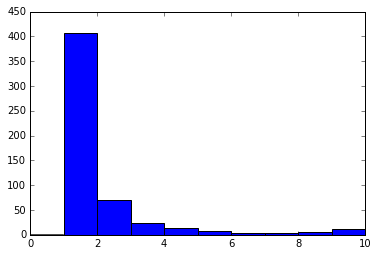

In [76]:
plt.hist(lenregs, range=(0, 10))

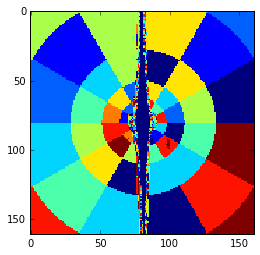

In [102]:
regid = np.zeros(f.image_dim)
for i, r in enumerate(regs):
    regid[f.anyreg_to_mask(r).reshape(f.image_dim)] = i
regid = np.mod(regid, 10)
plt.imshow(regid, interpolation='nearest')

In [26]:
reduced_images621 = remove_mediannorm(np.dstack(initial_fits_621), normperimF621, medianimF621)
reduced_images845 = remove_mediannorm(np.dstack(initial_fits_845), normperimF845, medianimF845)

       file        TARGNAME FILTER   ASN_ID  ...  DATE-OBS  TIME-OBS EXPTIME
------------------ -------- ------ --------- ... ---------- -------- -------
ibg467010_drz.fits   AH-VEL  F621M IBG467010 ... 2010-12-30 16:08:37     2.7
ibg446010_drz.fits   AP-PUP  F621M IBG446010 ... 2010-12-31 14:13:52    12.9
ibg453010_drz.fits   AP-SGR  F621M IBG453010 ... 2011-07-28 17:58:43     8.7
ibg422010_drz.fits   AV-CIR  F621M IBG422010 ... 2011-05-28 23:51:11    13.5
ibg443010_drz.fits   AW-PER  F621M IBG443010 ... 2010-10-07 05:39:27    14.4
ibg423010_drz.fits   AX-CIR  F621M IBG423010 ... 2011-07-27 05:32:37     3.3
ibg454010_drz.fits   BB-SGR  F621M IBG454010 ... 2011-08-09 03:06:07     8.7
ibg433010_drz.fits BETA-DOR  F621M IBG433010 ... 2010-10-10 14:06:03    1.44
ibg442010_drz.fits   BF-OPH  F621M IBG442010 ... 2011-05-23 22:06:39    12.3
ibg428010_drz.fits   BG-CRU  F621M IBG428010 ... 2010-10-22 06:52:12   2.085
               ...      ...    ...       ... ...        ...      ...     ...

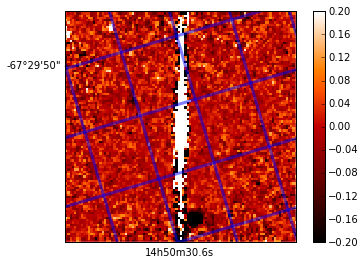

In [27]:
# Make a plot of one of the reduced datasets to compare with ds9 and check that I did not screw up the 
# coordinates somewhere -> looking at the masked values (which are unchanged in the fitting)
# this look good. 
i = 3
t = F621M[i]
print fitslist.summary[fitslist.summary['FILTER'] == 'F621M']
fig = plt.figure()
ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=t.wcs)
fig.add_axes(ax) 
im = ax.imshow(initial_fits_621[i], vmin=-.2, vmax=.2, cmap=plt.cm.gist_heat, origin='lower', interpolation='nearest')
plt.colorbar(im, ax=ax)
ra = ax.coords['ra']
dec = ax.coords['dec']
ra.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
dec.grid(color='b', alpha=0.5, linestyle='solid', linewidth=3)
ra.set_major_formatter('hh:mm:ss.s')

In [30]:
# Just print an example of how output source tables look and what the column names are
initial_sources_621[3]

<Table length=3>
  id    xcentroid     ycentroid   ...      flux           mag      
int64    float64       float64    ...    float64        float64    
----- ------------- ------------- ... ------------- ---------------
    1 49.4369921322 5.91004356828 ... 9.25162518194  -2.41554507389
    2 50.2021080975 10.9630283264 ... 11.2824621683  -2.63100971486
    3   19.41793404 92.9253640644 ... 1.33352976658 -0.312506785759

In [60]:
def check_matching_source_exists(l1, l2, d):
    '''
    
    This is not the most efficient way to do things, but very quick to code and
    runtime is not a concern for this.
    
    Parameters
    ----------
    l1, l2: two source lists
    d : float
         maximal distance in pix
    '''
    ind1 = []
    for i, s in enumerate(l1):
        dsquared = (s['xcentroid'] - l2['xcentroid'])**2 + (s['ycentroid'] - l2['ycentroid'])**2
        if np.min(dsquared) < d**2:
            ind1.append(i)
    return ind1
    
def combine_source_tables(list621, list845, names, dmax=10):
    '''Combine source tables. Input are two lists of tables in different bands.
    
    This function:
    - Only keeps sources if there is a source in the second band within ``dmax`` pixels.
    - Only keeps sources if at least one source is detected in both bands.
    - Adds a table column with the target name (form input ``names``)
    - stackes everything in one big table.
    '''
    finallist = []
    for i in range(len(list621)):
        l1 = list621[i]
        l2 = list845[i]

        if len(l1) > 0 and len(l2) > 0:
            l1 = l1[check_matching_source_exists(l1, l2, dmax)]
            if len(l1) > 0: # There are still sources left...
                l2 = l2[check_matching_source_exists(l2, l1, dmax)]
                # if there are still sources left...
                if len(l2) > 0:
                    l1['filter'] = 'F621M'
                    l2['filter'] = 'F845M'
                    l = vstack([l1, l2])
                    l['TARGNAME']= names[i]
                    finallist.append(l)
    return vstack(finallist)

In [32]:

initial_sources = combine_source_tables(initial_sources_621, initial_sources_845, F621names, dmax=5)
for col in ['xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'peak', 'flux', 'mag']:
    initial_sources[col].format='4.1f'

In [33]:
initial_sources

<Table length=255>
  id  xcentroid ycentroid sharpness ...   flux     mag   filter TARGNAME
int64  float64   float64   float64  ... float64  float64  str5    str8  
----- --------- --------- --------- ... -------- ------- ------ --------
    4      48.9      97.1       0.5 ...     25.1    -3.5  F621M   AP-PUP
   17      45.9      97.8       0.4 ...      9.6    -2.5  F845M   AP-PUP
    2      46.8      11.8       0.4 ...     30.1    -3.7  F621M   AP-SGR
    2      45.9       7.9       0.4 ...      4.0    -1.5  F845M   AP-SGR
    3      19.4      92.9       0.8 ...      1.3    -0.3  F621M   AV-CIR
    6      19.7      92.7       0.8 ...      1.0    -0.0  F845M   AV-CIR
    1      45.4      16.1       0.4 ...      6.4    -2.0  F621M   AW-PER
   25      43.7      19.4       0.3 ...      7.2    -2.1  F845M   AW-PER
    7      48.9      50.7       0.5 ...  41381.0   -11.5  F621M   AX-CIR
    9      56.6      53.5       0.3 ...      2.1    -0.8  F621M   AX-CIR
  ...       ...       ...       ... ...      ...     ...    ...      ...
    2      53.1      24.0       0.4 ...     40.6    -4.0  F845M    W-GEM
    3      45.4      50.0       0.5 ... 311365.9   -13.7  F621M    X-SGR
    2      45.2      50.0       0.6 ... 264220.2   -13.6  F845M    X-SGR
    2      51.8      28.0       0.6 ...  11868.9   -10.2  F621M    X-VUL
    3      53.1      30.8       0.3 ...      2.1    -0.8  F621M    X-VUL
    3      54.1      29.8       0.5 ...      3.0    -1.2  F845M    X-VUL
   12      52.1      93.1       0.4 ...     12.9    -2.8  F621M    Y-SGR
    6      53.1      92.1       0.7 ...      1.6    -0.5  F845M    Y-SGR
   15      31.8      84.7       0.8 ...      4.1    -1.5  F621M ZETA-GEM
    1      28.1      82.0       0.8 ...      1.5    -0.4  F845M ZETA-GEM

In [46]:
def targname(n):
    n = n.replace('-', ' ')
    n = n.replace('BETA', r'$\beta$')
    n = n.replace('ZETA', r'$\zeta$')
    n = n.replace('ETA', r'$\eta$')
    n = n.replace('DEL', r'$\delta$')
    if ' ' not in n:
        n = n[:-3] + ' ' + n[-3:]
    n = n[:-2] + n[-2:].lower()
    return n

In [194]:
def plot_gallery_source(images, names, cutouts, sources=None, n_cols=4, n_rows=5):
    '''
    Parameters
    ----------
    images : list of 2d arrays or 3d array 
        either a list of images or a 3d array with images stacked along the last dimension
    '''
    xl, xr = 0., 0.
    yt, yb = 0., 0.

    dx = (1. - xl - xr) / n_cols
    dy = (1. - yt - yb) / n_rows

    xspacer = 0.1 * dx
    yspacer = 0.1 * dy

    fig = plt.figure(figsize=(15,20))
    for i in range(n_rows):
        for j in range(n_cols):
            index = i * n_cols + j
            x0 = xl + j * dx
            y0 = 1. - yt - (i + 1) * dy
            ax = WCSAxes(fig, [x0 + xspacer, y0 + yspacer, dx - 2 * xspacer, dy - 2 * yspacer], wcs=cutouts[index].wcs)
            fig.add_axes(ax)
            if type(images) is list:
                im = images[index]
            else:
                im = images[..., index]
            im = ax.imshow(im, cmap=plt.cm.gray, origin='lower', interpolation='nearest',
                           vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))
            #plt.colorbar(im, ax=ax)
            ra = ax.coords['ra']
            dec = ax.coords['dec']
            ra.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            dec.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            ra.set_major_formatter('hh:mm:ss.s')
            ax.set_title(targname(names[index]))
            if sources is not None:
                # Pick different radii, otherwise one circle can cover up the circle below
                for f, color, radius in zip(['F621M', 'F845M'], ['b', 'r'], [5, 7]):
                    ind = (sources['filter'] == f) & (sources['TARGNAME'] == names[index])
                    if ind.sum() > 0:
                        apertures = photutils.CircularAperture(zip(sources['xcentroid'][ind], sources['ycentroid'][ind]), r=radius)
                        apertures.plot(color=color, lw = 3.)
    return fig

In [76]:
def plot_compare_filters(images1, cutouts1, images2, cutouts2, names, sources=None, n_rows=5):
    '''
    Parameters
    ----------
    images : list of 2d arrays or 3d array 
        either a list of images or a 3d array with images stacked along the last dimension
    '''
    xl, xr = 0., 0.
    yt, yb = 0., 0.

    n_cols = 4
    
    dx = (1. - xl - xr) / n_cols
    dy = (1. - yt - yb) / n_rows

    xspacer = 0.1 * dx
    yspacer = 0.1 * dy

    fig = plt.figure(figsize=(15,20))
    for j in range(n_rows):
        for i in range(n_cols):
            indexnumber = j * n_cols + i
            index = indexnumber // 2
            if np.mod(indexnumber, 2) == 0:
                images = images1
                cutouts = cutouts1
            else:
                images = images2
                cutouts = cutouts2
            x0 = xl + i * dx
            y0 = 1. - yt - (j + 1) * dy
            ax = WCSAxes(fig, [x0 + xspacer, y0 + yspacer, dx - 2 * xspacer, dy - 2 * yspacer], wcs=cutouts[index].wcs)
            fig.add_axes(ax)
            if type(images) is list:
                im = images[index]
            else:
                im = images[..., index]
            im = ax.imshow(im, cmap=plt.cm.gray, origin='lower', interpolation='nearest',
                           vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))
            #plt.colorbar(im, ax=ax)
            ra = ax.coords['ra']
            dec = ax.coords['dec']
            ra.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            dec.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
            ra.set_major_formatter('hh:mm:ss.s')
            ax.set_title(targname(names[index]))
            if sources is not None:
                # Pick different radii, otherwise one circle can cover up the circle below
                for f, color, radius in zip(['F621M', 'F845M'], ['b', 'r'], [5, 7]):
                    ind = (sources['filter'] == f) & (sources['TARGNAME'] == names[index])
                    if ind.sum() > 0:
                        apertures = photutils.CircularAperture(zip(sources['xcentroid'][ind], sources['ycentroid'][ind]), r=radius)
                        apertures.plot(color=color, lw = 3.)
    return fig

In [158]:
#fig = plot_gallery(initial_fits_621, F621names, F621M, initial_sources, 5, 7)

In [159]:
reduced_images = remove_mediannorm(np.dstack(initial_fits_621), normperimF621, medianimF621)

#fig = plot_gallery(reduced_images, F621names, F621M, initial_sources, 5, 7)

In [160]:
reduced_images = remove_mediannorm(np.dstack(initial_fits_845), normperimF845, medianimF845)

#fig = plot_gallery(reduced_images, F845names, F845M, initial_sources, 5, 7)

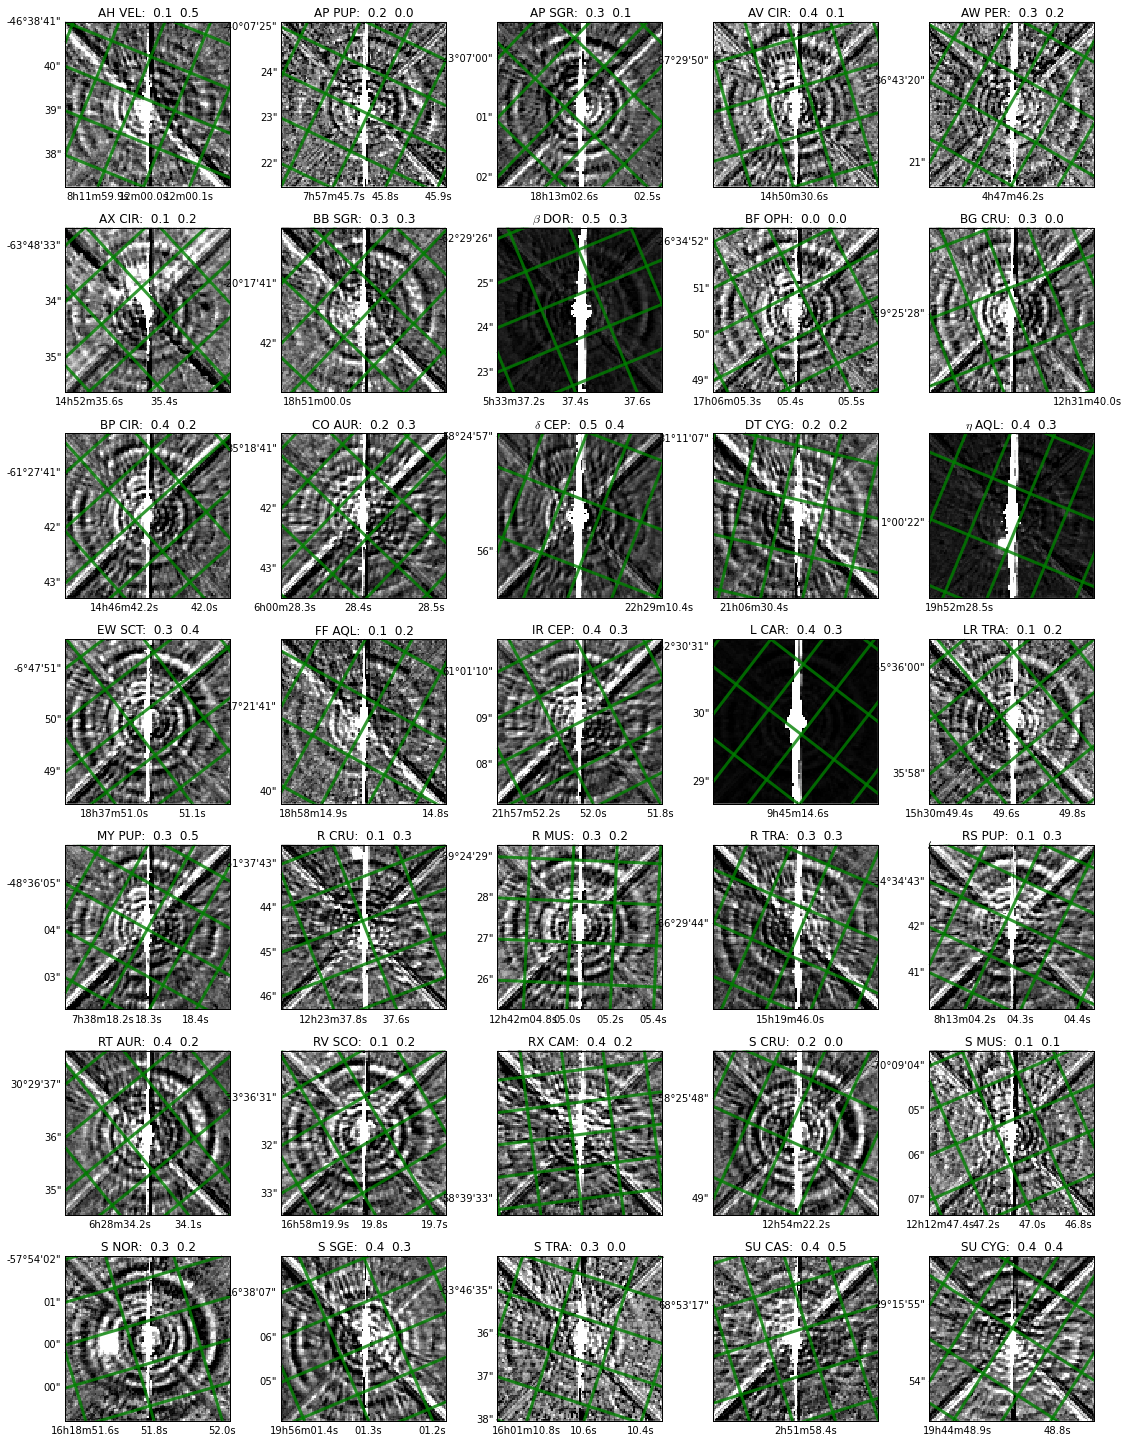

In [80]:
% matplotlib inline
names = []
for n, c in zip(F621names, F621M):
    names.append('{0}: {1:4.1f} {2:4.1f}'.format(n, c.input_position_cutout[0] - c.center_cutout[0],
                                                 c.input_position_cutout[1] - c.center_cutout[1]))
fig = plot_gallery(normF621, names, F621M, initial_sources, 5, 7)

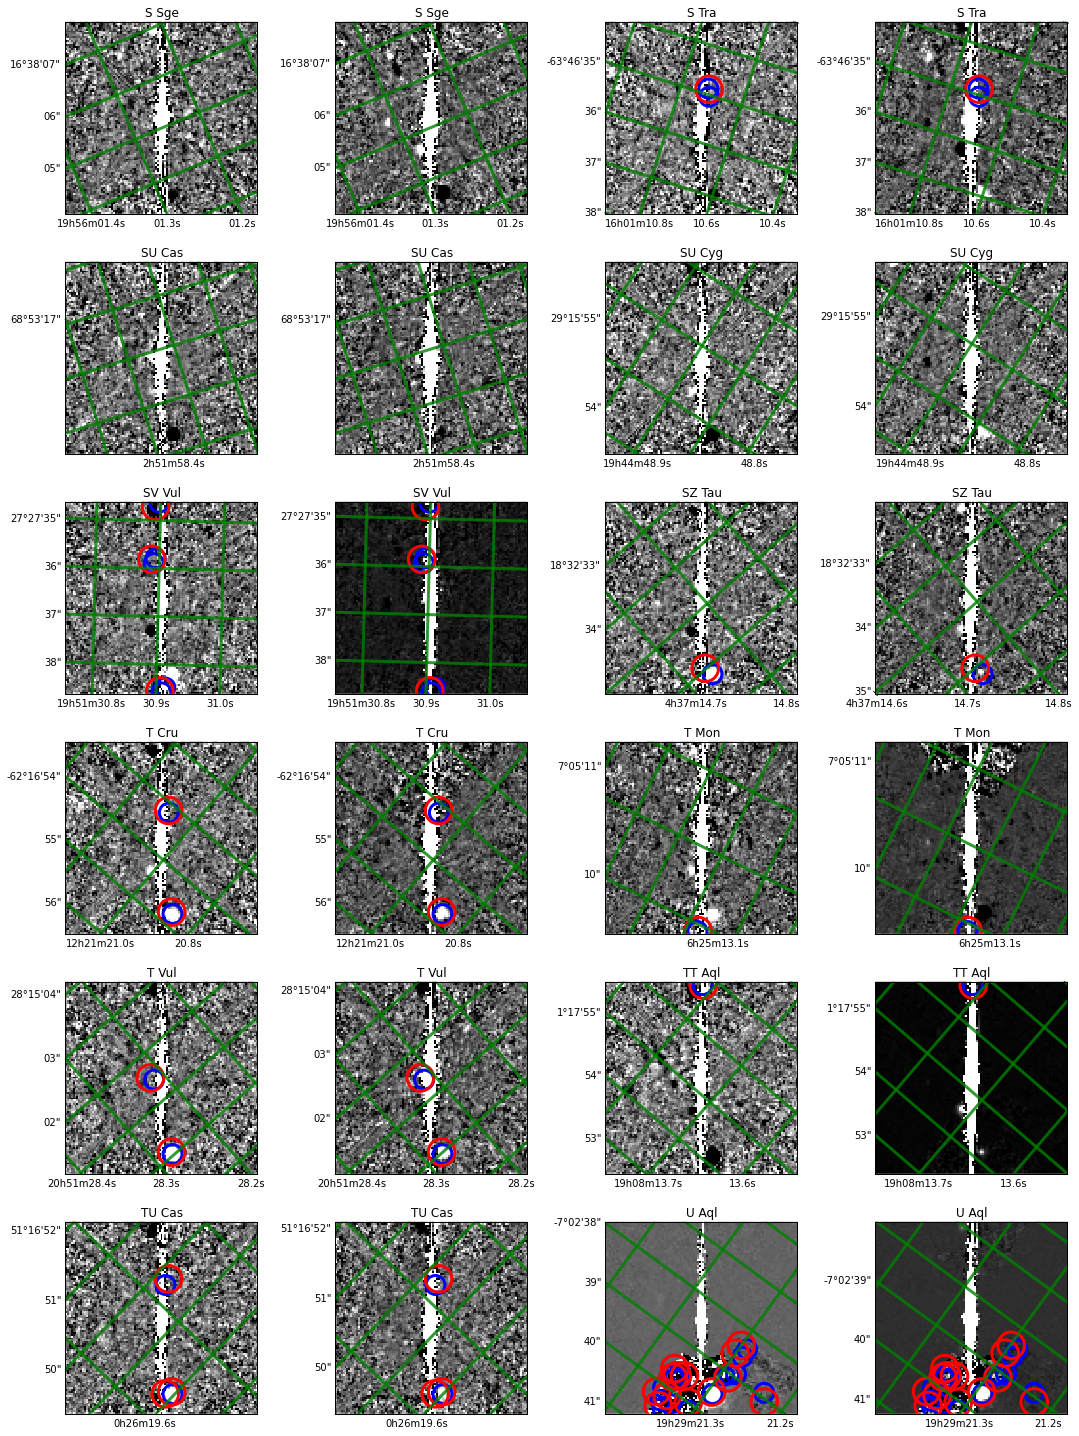

In [44]:
start = 31
fig = plot_compare_filters(initial_fits_621[start:], F621M[start:], initial_fits_845[start:], F845M[start:], 
                           F621names[start:], initial_sources, n_rows=6)

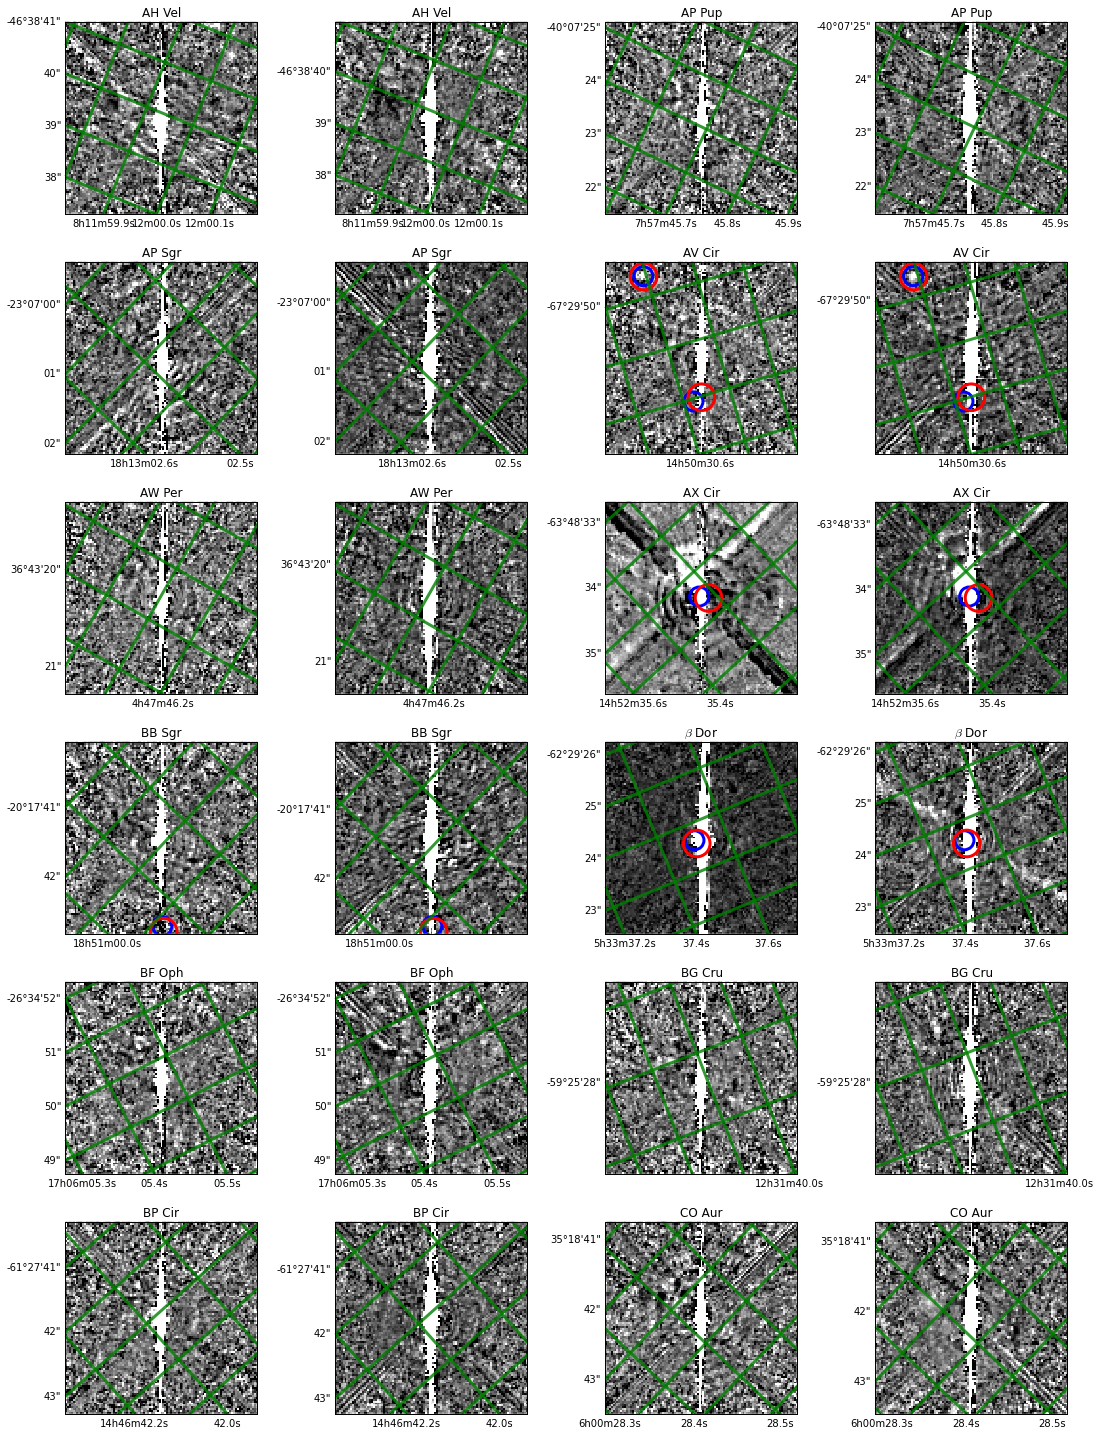

In [171]:
fig = plot_compare_filters(initial_fits_621, F621M, initial_fits_845, F845M, F621names, initial_sources, n_rows=6)

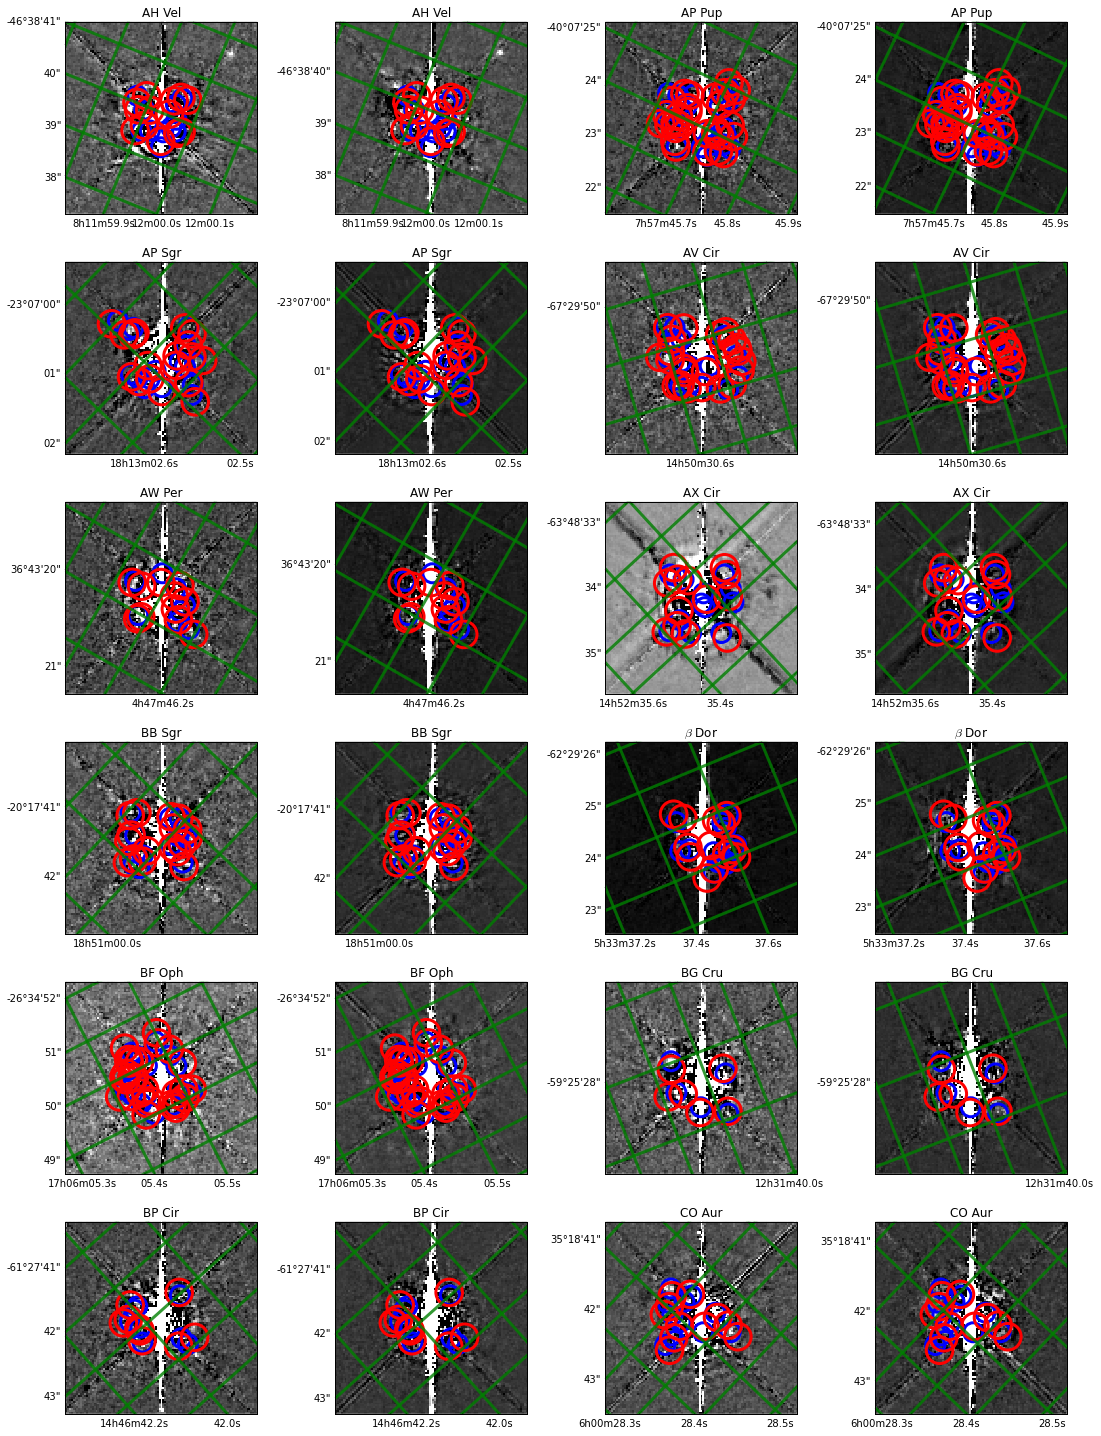

In [176]:


fig = plot_compare_filters(reduced_images621, F621M, reduced_images845, F845M, F621names, initial_sources, n_rows=6)

In [ ]:
# Why is the top right compagion in AH Vel not found?
# Why is the whooping bright AX CIR (just top left of the cepheid) not found?

# Maybe I should do the source detection on the real images, not the scales images?
# -> No. I onlt get to see PSF artifact in the middle of the images and NONE of the good compangions.

# Once that works, I'll mask the regions with detected compagnions and run through everything again.
# That should (fingers crossed!) give a better subtraction for e.g. AX Cir where the current fit is certainly distorted.

In [ ]:
# Vegamag zero points are here http://www.stsci.edu/hst/wfc3/phot_zp_lbn

# Units in image are electrons/s
# Images are drz -> drizzeled -> pixels are all same size.


def flux2magF621M(x):
    return -2.5 * np.log10(x) + 24.4539


def flux2magF845M(x):
    return -2.5 * np.log10(x) + 23.2809

In [ ]:







halfwidth = 50
daofindkwargs = {'fwhm': 1.5, 'threshold': 7, 'roundlo': -0.8, 'roundhi': 0.8}

fluxes, imout, scaledout = detection.photometryloop(images, targets, **daofindkwargs)
fluxes.add_column(MaskedColumn(flux2magF621M(fluxes['flux_fit']), 'mag_fit'))
fluxes.add_column(MaskedColumn(['F621M'] * len(fluxes), 'filter'))
#detection.plot_gallery('PSF subtr. - linear scale', imout, 10, 7, sources=fluxes)
#detection.plot_gallery('PSF subtr. - funny scale', scaledout, 10, 7, sources=fluxes)
# Get rid of negative fluxes. They must be fit artifacts
# Investigate later where they come from.
fluxes = fluxes[~fluxes['mag_fit'].mask]